<a href="https://colab.research.google.com/github/thalesgmendes/Catalogo-de-Plantas/blob/main/Codigos/Schedulers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Estratégias de Agendamento de Taxa de Aprendizado (Schedulers)

###1. Step Decay
A taxa de aprendizado começa em 0,1 e é reduzida em 90% a cada 20 épocas.

###2. Exponential Decay
A taxa de aprendizado começa em 0,1 e decai de forma exponencial a cada época, com um fator de decaimento de 0,05.

###3. Cosine Annealing
A taxa de aprendizado começa em 0,1 e diminui suavemente até 0,001, seguindo uma curva cosseno, ou seja, não sobe.

###4 Cyclic Learning Rate
A taxa de aprendizado oscila entre 0,001 e 0,1, subindo e descendo em ciclos de 20 épocas.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

plt.style.use('seaborn-v0_8')

## Step Decay

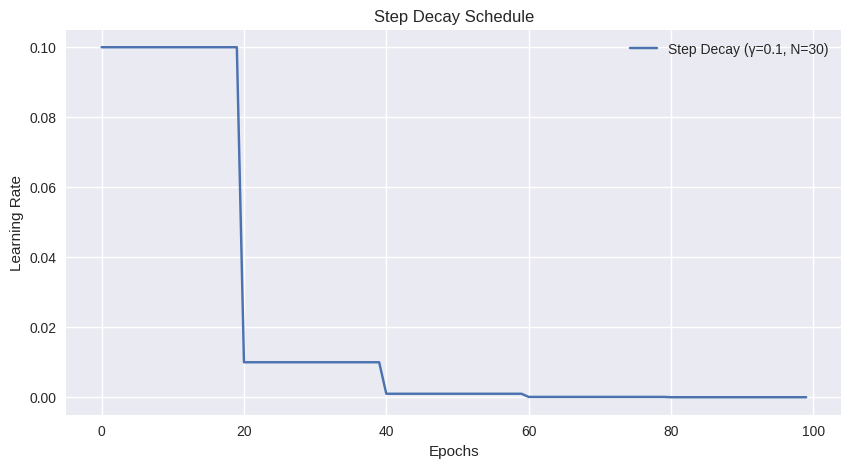

In [2]:
def step_decay(epoch, initial_lr=0.1, decay_rate=0.1, decay_steps=20):
    return initial_lr * (decay_rate ** (epoch // decay_steps))

# Plot
epochs = 100
lr_step = [step_decay(e) for e in range(epochs)]

plt.figure(figsize=(10,5))
plt.plot(lr_step, label=f'Step Decay (γ={0.1}, N={30})')
plt.title("Step Decay Schedule")
plt.xlabel("Epochs"), plt.ylabel("Learning Rate")
plt.legend(), plt.grid(True)
plt.show()

## Exponential Decay



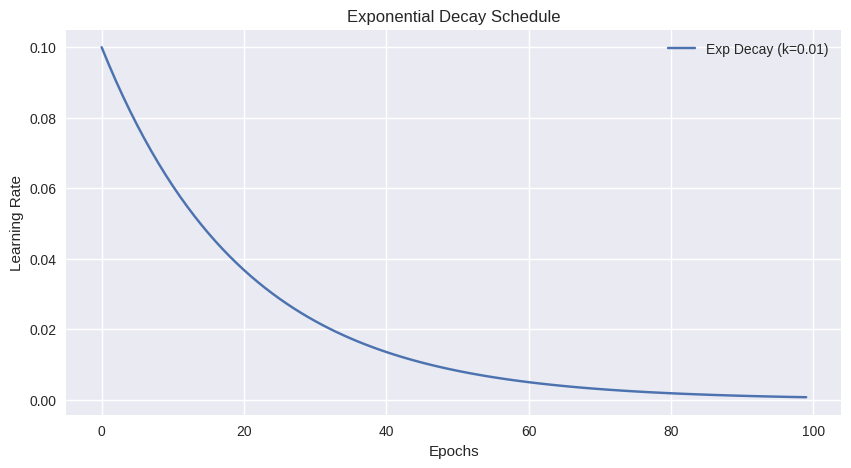

In [8]:
def exp_decay(epoch, initial_lr=0.1, k=0.05):
    return initial_lr * math.exp(-k * epoch)


epochs = 100
# Plot
lr_exp = [exp_decay(epoch) for epoch in range(epochs)]

plt.figure(figsize=(10,5))
plt.plot(lr_exp, label=f'Exp Decay (k={0.01})')
plt.title("Exponential Decay Schedule")
plt.xlabel("Epochs"), plt.ylabel("Learning Rate")
plt.legend(), plt.grid(True)
plt.show()

## Cosine Annealing



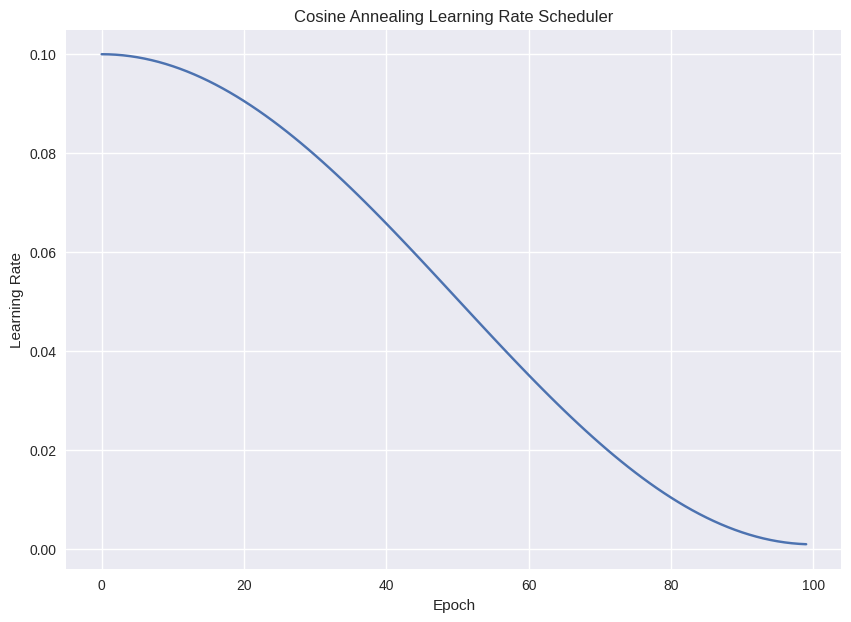

In [4]:
def cosine_lr(epoch, lr_min=0.001, lr_max=0.1, max_epochs=100):
    return lr_min + 0.5 * (lr_max - lr_min) * (1 + np.cos(epoch / max_epochs * np.pi))


# Plot
lr_cosine = [cosine_lr(epoch) for epoch in range(epochs)]

plt.figure(figsize=(10, 7))
plt.plot(lr_cosine)
plt.title("Cosine Annealing Learning Rate Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

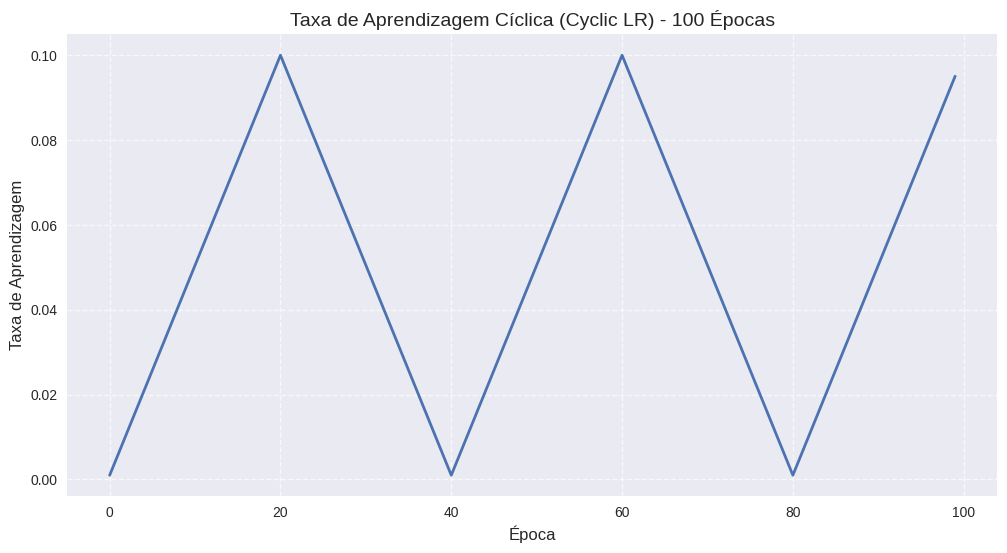

In [5]:
def cyclic_lr(epoch, T=20, eta_max=0.1, eta_min=0.001):
    cycle = math.floor(1 + epoch / (2 * T))
    x = abs(epoch / T - 2 * cycle + 1)
    return eta_min + (eta_max - eta_min) * max(0, 1 - x)


epochs = range(100)

# Calcular valores de LR para cada época
lr_values = [cyclic_lr(epoch) for epoch in epochs]

# %%
# Plotar a curva
plt.figure(figsize=(12, 6))
plt.plot(epochs, lr_values, linewidth=2)
plt.title('Taxa de Aprendizagem Cíclica (Cyclic LR) - 100 Épocas', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Taxa de Aprendizagem', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


## Comparação entre diferentes estratégias de agendamento da taxa de aprendizado para treinar uma rede neural no dataset MNIST.



In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.optimizers import Adam
import math
import random
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Defini sementes para reprodutibilidade

In [15]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## Carrega os dados MNIST, normaliza valores de pixel e prepara divisões de treino/validação

In [16]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalização
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0

# Flatten para entrada na rede
x_train_full = x_train_full.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train_full, _, y_train_full, _ = train_test_split(x_train_full, y_train_full, train_size=10000, random_state=seed, stratify=y_train_full)

# One-hot encoding
y_train_full = tf.keras.utils.to_categorical(y_train_full, 10)

# Separando treino e validação com seed fixa
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=seed, stratify=np.argmax(y_train_full, axis=1))

##Defini a Arquitetura do Modelo

In [22]:
# Cria uma rede neural simples com uma camada oculta
def create_model():
    return tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(784,)),
        layers.Dense(10, activation='softmax')
    ])

##Treinamento com Agendadores de LR
Nesta seção, realizamos o treinamento do modelo utilizando diferentes  estratégias de agendamento da taxa de aprendizado ao longo de 100 épocas.

In [23]:
# Callback para armazenar os valores de learning rate a cada época
class LrHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        self.lrs.append(float(self.model.optimizer.learning_rate.numpy()))

# Treinamento com scheduler
def train_scheduler(schedule_fn=None, callback=None):
    model = create_model()
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    lr_history = LrHistory()

    if schedule_fn:
        callback = callbacks.LearningRateScheduler(schedule_fn)

    history = model.fit(
        x_train, y_train,
        epochs=80,
        validation_data=(x_val, y_val),
        callbacks=[callback, lr_history],
        verbose=0
    )

    return history, lr_history.lrs

# Dicionário de agendadores
schedulers = {
    'Step Decay': (lambda epoch: step_decay(epoch), None),
    'Exponential Decay': (lambda epoch: exp_decay(epoch), None),
    'Cosine Annealing': (lambda epoch: cosine_lr(epoch), None),
    'Cyclic LR': (lambda epoch: cyclic_lr(epoch), None),
}

# Executar treinamentos
results = {}
lrs_logs = {}

for name, (schedule, callback) in schedulers.items():
    print(f"Treinando com {name}...")
    history, lrs = train_scheduler(schedule, callback)
    results[name] = history
    lrs_logs[name] = lrs

Treinando com Step Decay...
Treinando com Exponential Decay...
Treinando com Cosine Annealing...
Treinando com Cyclic LR...


##Curvas de Perda no Treinamento
Esse gráfico mostra a perda durante o treinamento ao longo das 100 épocas para cada scheduler.

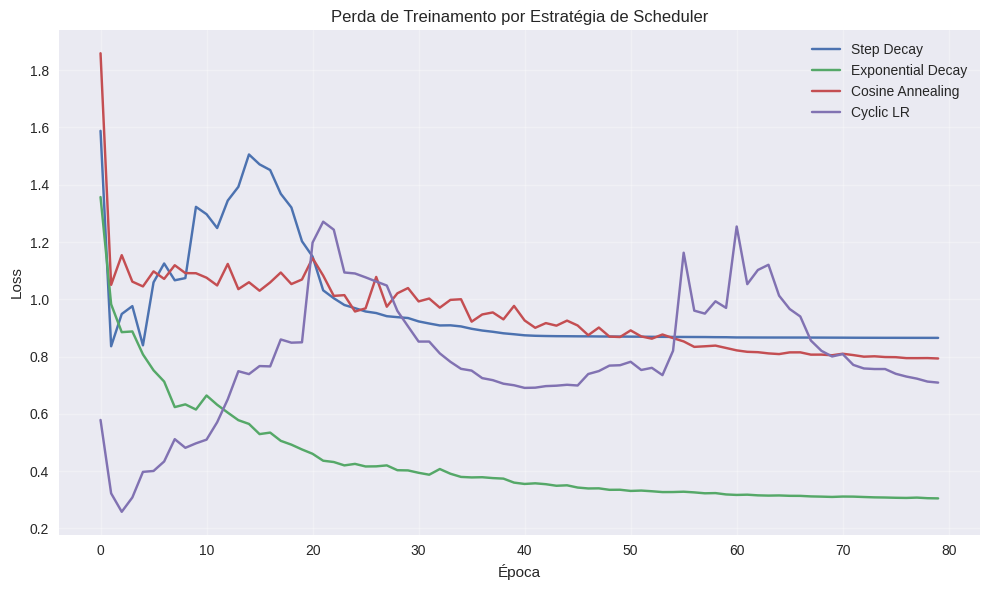

In [24]:
# Gráfico de perda de treino
plt.figure(figsize=(10, 6))
plt.title('Perda de Treinamento por Estratégia de Scheduler')
for name, history in results.items():
    plt.plot(history.history['loss'], label=name)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##Curvas de Perda na Validação
Esse gráfico mostra a perda na validação para cada estratégia ao longo das 100 épocas para cada scheduler.

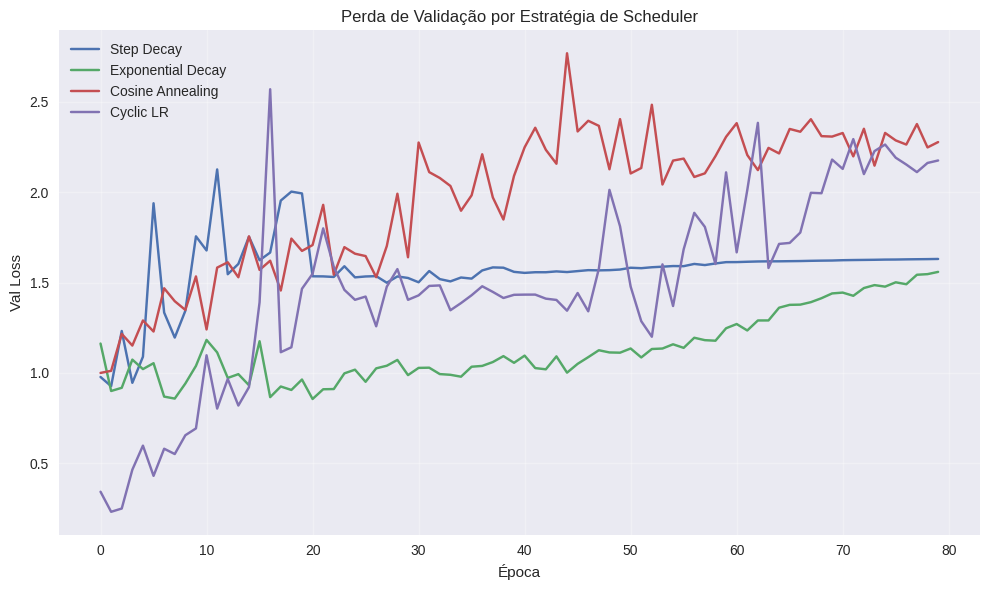

In [25]:
# Gráfico de perda de validação
plt.figure(figsize=(10, 6))
plt.title('Perda de Validação por Estratégia de Scheduler')
for name, history in results.items():
    plt.plot(history.history['val_loss'], label=name)
plt.xlabel('Época')
plt.ylabel('Val Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##Escalonamento da Taxa de Aprendizado
Abaixo, o escalonamento da learning rate (taxa de aprendizado) ao longo das épocas, como definido por cada função de agendamento.

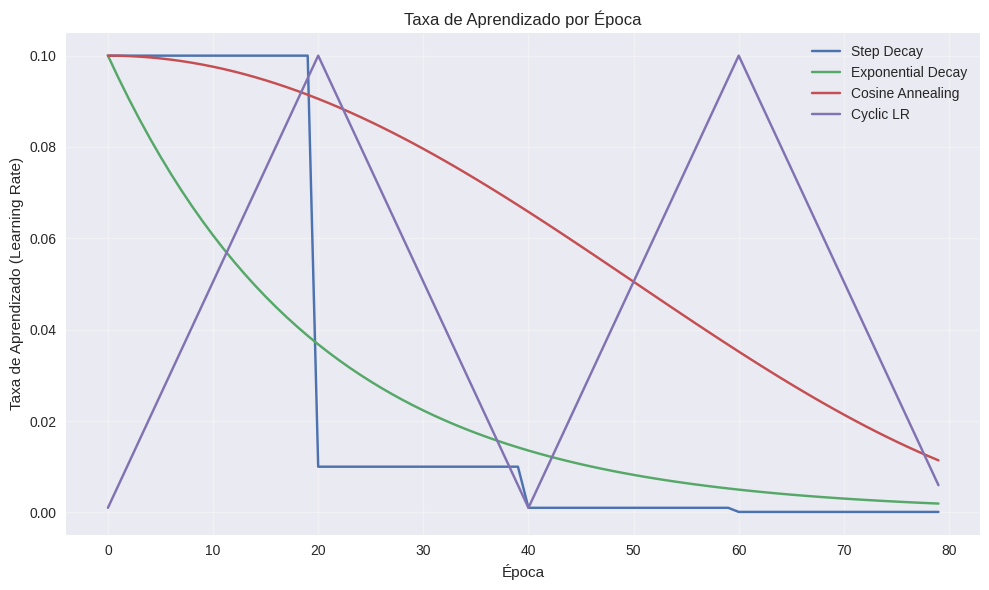

In [26]:
plt.figure(figsize=(10, 6))
plt.title('Taxa de Aprendizado por Época')
for name, lrs in lrs_logs.items():
    plt.plot(lrs, label=name)
plt.xlabel('Época')
plt.ylabel('Taxa de Aprendizado (Learning Rate)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##Resultados Finais
A tabela a seguir mostra os valores finais de perda e acurácia para os dados de treinamento e validação.

In [27]:
# Mostra métricas finais de cada estratégia
print("\nResultados Finais por Estratégia:")
print("-" * 60)
print(f"{'Scheduler':<20} | {'Train Loss':<10} | {'Val Loss':<10} | {'Train Acc':<10} | {'Val Acc':<10}")
print("-" * 60)

for name, history in results.items():
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    print(f"{name:<20} | {train_loss:<10.3f} | {val_loss:<10.3f} | {train_acc:<10.3f} | {val_acc:<10.3f}")



Resultados Finais por Estratégia:
------------------------------------------------------------
Scheduler            | Train Loss | Val Loss   | Train Acc  | Val Acc   
------------------------------------------------------------
Step Decay           | 0.865      | 1.631      | 0.637      | 0.623     
Exponential Decay    | 0.305      | 1.559      | 0.876      | 0.826     
Cosine Annealing     | 0.793      | 2.277      | 0.656      | 0.646     
Cyclic LR            | 0.709      | 2.176      | 0.705      | 0.683     
